In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [21]:
import pandas as pd

# 파일 경로
file_path = r'C:\Users\bluecom011\Desktop\공모전\최종데이터(한글) - 최종데이터(한글).csv'

# CSV 파일 읽기
data = pd.read_csv(file_path, encoding='utf-8')

# 데이터의 처음 몇 행을 표시
data.head()


,자치구,경도,위도,장애인구수,평균 도로혼잡도,주차장,복지시설,과태료건수,부과액,평균차량빈도,장애인고용자수
0,강동구,127.153334,37.548510,18785,55.9,15517,51,2307,184200000,62.1,310
1,송파구,127.124191,37.497060,20571,52.8,22745,50,4656,409090000,52.1,764
2,강남구,127.075020,37.487902,15158,44.6,20566,56,6135,546904200,56.1,1211
3,서초구,127.039196,37.464048,10158,48.6,14690,30,3257,269840000,54.8,608
4,관악구,126.945904,37.464788,20228,48.6,20446,25,1776,152020000,40.2,235


고용자: 강남 송파 영등 
복지: 노원 강남 강서 강동 송파
주차장 송파 관악 강남

# 강남,송파로 결정!



장애인고용자수     0.619094
복지시설        0.477912
주차장         0.372685

In [16]:
# 상관 계수 분석을 위한 필요한 열 선택
analysis_columns = ['장애인구수', '평균 도로혼잡도', '주차장', '복지시설', '부과액', '평균차량빈도', '장애인고용자수', '과태료건수']

# 선택된 열을 사용하여 상관 계수 계산
correlation_matrix = data[analysis_columns].corr()

# '과태료건수'와의 상관 계수 표시
correlation_with_fines = correlation_matrix['과태료건수'].sort_values(ascending=False)
correlation_with_fines


과태료건수       1.000000
부과액         0.995416
장애인고용자수     0.619094
복지시설        0.477912
주차장         0.372685
장애인구수       0.271425
평균차량빈도     -0.155404
평균 도로혼잡도   -0.188205
Name: 과태료건수, dtype: float64

c:\Users\bluecom011\miniconda3\envs\OpenAI\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


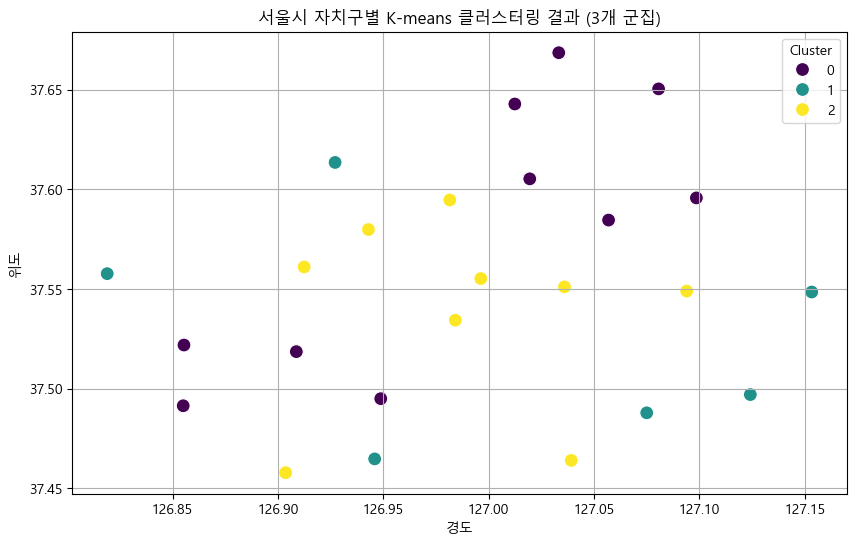

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터링에 사용할 변수 선택
clustering_columns = ['장애인고용자수', '복지시설', '주차장', '장애인구수']
clustering_data = data[clustering_columns]

# K-means 클러스터링 (3개의 클러스터)
kmeans = KMeans(n_clusters=3, random_state=0).fit(clustering_data)
data['Cluster'] = kmeans.labels_

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='경도', y='위도', hue='Cluster', palette='viridis', s=100)
plt.title('서울시 자치구별 K-means 클러스터링 결과 (3개 군집)')
plt.xlabel('경도')
plt.ylabel('위도')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [18]:
# 각 클러스터별 평균 값 계산
cluster_means = data.groupby('Cluster')[clustering_columns].mean()

# 클러스터별 평균 값 표시
cluster_means


,장애인고용자수,복지시설,주차장,장애인구수
Cluster,,,,
0,308.400000,23.700000,9995.4,17757.000000
1,495.833333,46.666667,19196.0,20830.333333
2,434.333333,18.000000,10178.0,9923.000000


In [19]:
# 클러스터 1에 해당하는 지역군 추출
cluster_1_areas = data[data['Cluster'] == 1]['자치구'].tolist()
cluster_1_areas


['강동구', '송파구', '강남구', '관악구', '강서구', '은평구']

### 클러스터 0은 
장애인고용자수와 장애인구수가 상대적으로 낮은 지역으로, 주차장 수도 중간 수준입니다. 

이러한 지역은 장애인 불법 주차 예방 장치 설치에 있어 중간 정도의 우선순위를 가질 수 있습니다.

### 클러스터 1은 
장애인고용자수와 장애인구수가 높은 지역으로, 주차장 수와 복지시설의 수도 많습니다. 

이러한 지역은 장애인 불법 주차 예방 장치 설치에 있어 높은 우선순위를 가질 수 있으며, 특히 복지시설이 많은 지역에 중점을 둘 수 있습니다.

### 클러스터 2는 
장애인고용자수가 가장 낮고, 주차장 수도 낮은 편입니다. 장애인구수는 클러스터 1과 유사합니다. 

이러한 지역은 장애인 불법 주차 예방 장치 설치에 있어 낮은 우선순위를 가질 수 있으나, 장애인구수가 높은 것을 고려하여 특정 지역에 대한 추가적인 분석이 필요할 수 있습니다.

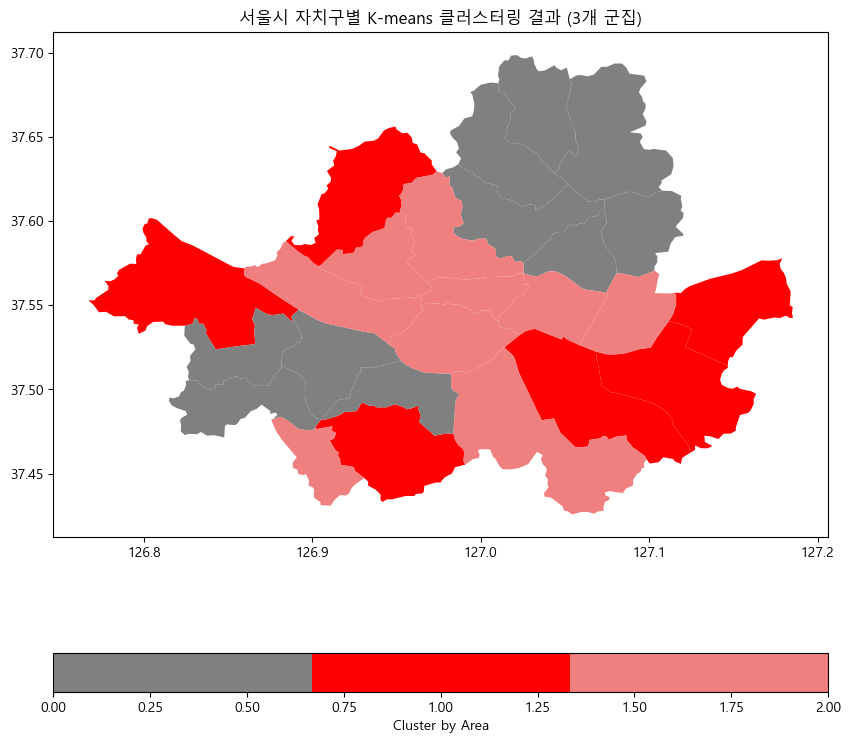

In [20]:
import requests
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 서울 행정구역 지리적 경계 데이터 가져오기
url = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
response = requests.get(url)
seoul_geo = json.loads(response.content)

# GeoDataFrame 생성
gdf = gpd.GeoDataFrame.from_features(seoul_geo['features'])

# 기존 데이터프레임과 GeoDataFrame 병합
merged_data = gdf.merge(data, left_on='name', right_on='자치구')

# 클러스터 0을 회색, 클러스터 2를 연한 빨간색으로 표시할 색상맵 생성
cmap = ListedColormap(['gray', 'red', 'lightcoral'])  # 클러스터 0은 'gray', 클러스터 2는 'lightcoral'로 지정합니다.

# 지도 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='Cluster', ax=ax, legend=True, legend_kwds={'label': "Cluster by Area", 'orientation': "horizontal"}, cmap=cmap)

plt.title('서울시 자치구별 K-means 클러스터링 결과 (3개 군집)')
plt.show()


In [22]:
# 재실행을 위한 필요한 라이브러리와 데이터 재로드
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 독립 변수와 종속 변수 설정 ('경도'와 '위도' 제외)
X = data[['장애인구수', '평균 도로혼잡도', '주차장', '복지시설', '부과액', '평균차량빈도', '장애인고용자수']]
y = data['과태료건수']

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 선형 회귀 모델 생성 및 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 회귀 계수 출력
regression_coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
regression_coefficients


,Coefficient
장애인구수,0.003178
평균 도로혼잡도,-3.845548
주차장,0.000183
복지시설,6.670114
부과액,0.000011
평균차량빈도,3.679273
장애인고용자수,0.095799


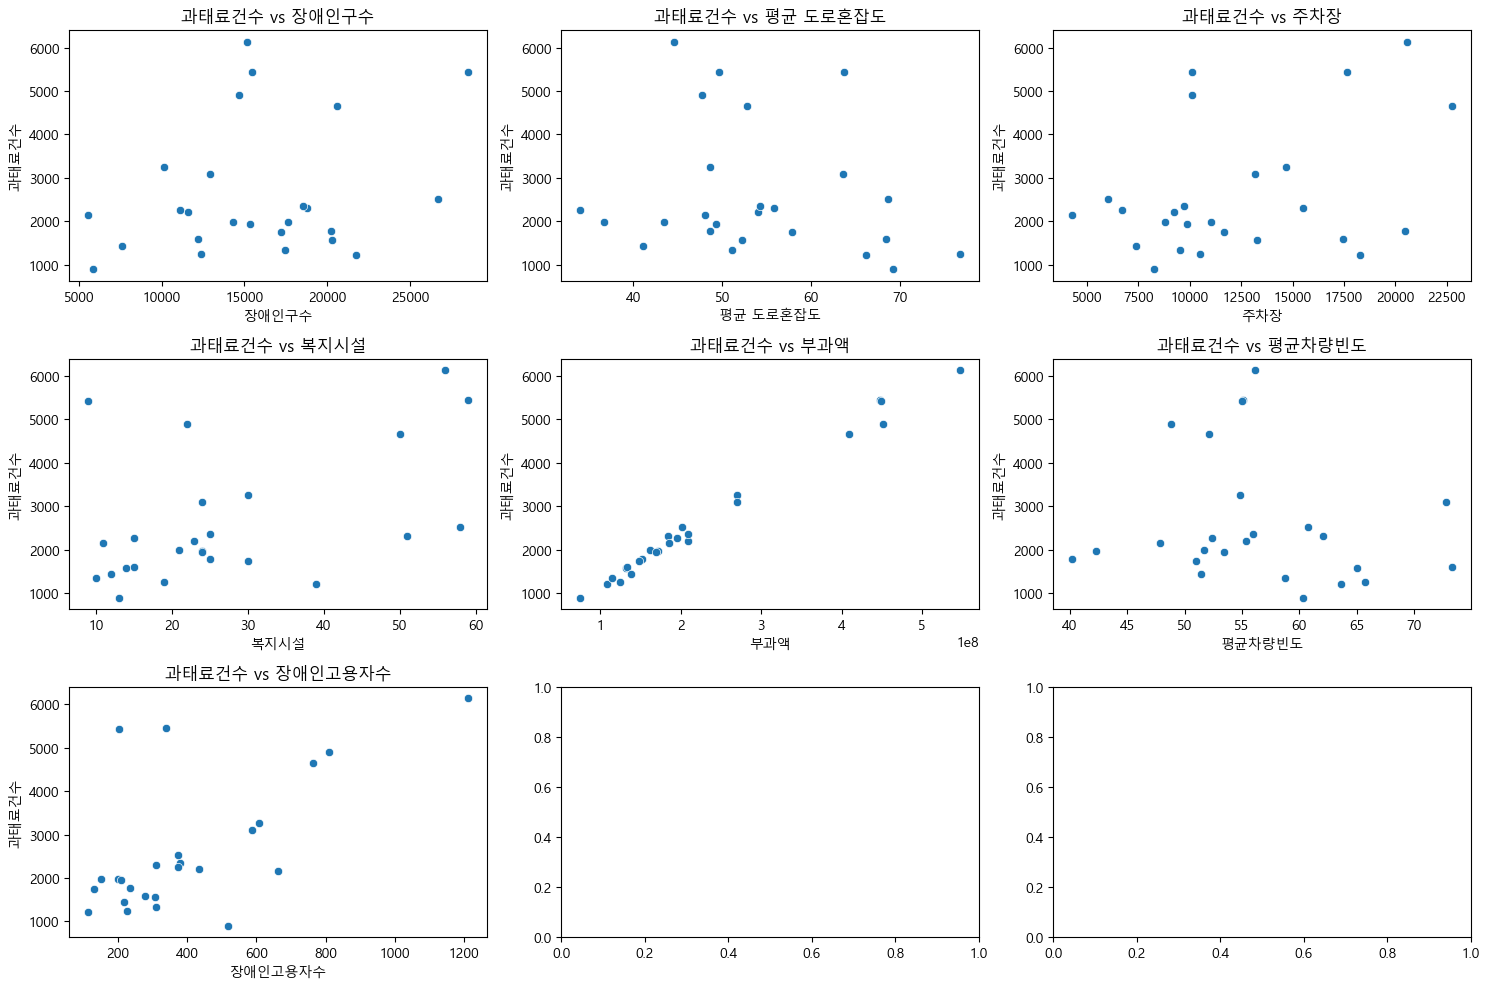

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 독립 변수 재정의
X = data[['장애인구수', '평균 도로혼잡도', '주차장', '복지시설', '부과액', '평균차량빈도', '장애인고용자수']]

# 각 독립 변수에 대한 선형성 확인을 위한 시각화 재실행
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, col in enumerate(X.columns):
    sns.scatterplot(data=data, x=col, y='과태료건수', ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'과태료건수 vs {col}')
    axs[i//3, i%3].set_xlabel(col)
    axs[i//3, i%3].set_ylabel('과태료건수')

# 레이아웃 조정
plt.tight_layout()
plt.show()


고용자, 부과액, 주차장, 인구수..?

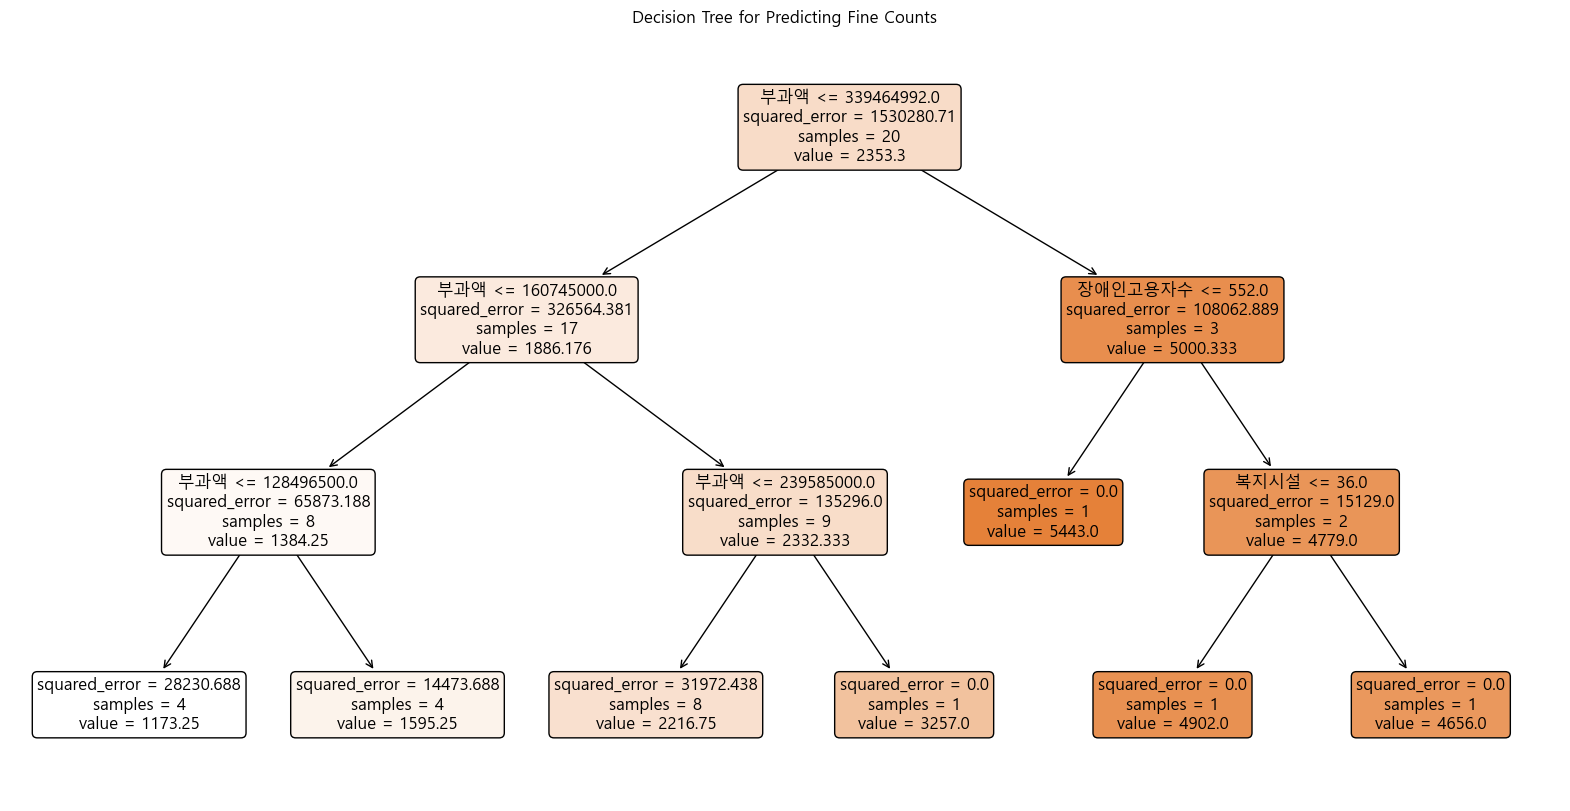

In [23]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# 의사결정 나무 모델 생성
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=0) # 깊이를 3으로 제한
dt_regressor.fit(X_train, y_train)

# 의사결정 나무 시각화
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, feature_names=X.columns, filled=True, rounded=True, fontsize=12)
plt.title('Decision Tree for Predicting Fine Counts')
plt.show()
